# Put the R in RAG

In [3]:
# Debug pinecone installation
!pip show pinecone

Name: pinecone
Version: 6.0.2
Summary: Pinecone client and SDK
Home-page: https://www.pinecone.io
Author: Pinecone Systems, Inc.
Author-email: support@pinecone.io
License: Apache-2.0
Location: c:\Users\kadda\github_repos\rag-gen-ai\.venv\Lib\site-packages
Requires: certifi, pinecone-plugin-interface, python-dateutil, typing-extensions, urllib3
Required-by: 


In [4]:
from openai import OpenAI
from pinecone import Pinecone, ServerlessSpec
from bs4 import BeautifulSoup

import hashlib
import os
from dotenv import load_dotenv

from datetime import datetime

from tqdm import tqdm

c:\Users\kadda\github_repos\rag-gen-ai\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
load_dotenv()
# Retrieve the Pinecone API key from user data
pinecone_api_key = os.environ.get("PINECONE_API_KEY")

print(f"API key loaded: {pinecone_api_key[:3]}..." if pinecone_api_key else "No API key found")

# Initialize the OpenAI client
openai_client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# Define constants [vector size, embedding engine] small: 1536 medium: 4096 large: 12288
ENGINE = 'text-embedding-3-small'

# Initialize Pinecone client
pc = Pinecone(
    pinecone_api_key=pinecone_api_key
)

API key loaded: pcs...


In [6]:
INDEX_NAME = 'semantic-search-rag-index' # name of the collection of documents
NAMESPACE = 'default' # split the documents into namespaces. default is 'default'

def get_embeddings(text, engine=ENGINE):
    """
    Get the embeddings for a given text using OpenAI's API.
    """
    response = openai_client.embeddings.create(
            input=text,
            model=engine
        )
    return [data.embedding for data in list(response.data)]

def get_embedding(text, engine=ENGINE):
    """
    Get the embedding for a given text using OpenAI's API.
    Use the get_embeddings function to get the embedding for a single text
    """
    return get_embeddings(text, engine)[0]

len(get_embedding("Hello world!")), len(get_embeddings(["Hello world!", "Servus Welt"]))


(1536, 2)

In [7]:
if INDEX_NAME not in pc.list_indexes().names():
    # Create the index if it doesn't exist
    pc.create_index(
        name=INDEX_NAME, # name of the index
        dimension=1536, # dimension of the embedding for OpenAI's text-embedding-3-small
        metric='cosine', # metric for similarity search
        spec=ServerlessSpec(
            cloud='aws',
            region='us-east-1',
        )
    )

# Store the index as variable
index = pc.Index(INDEX_NAME)
index

In [8]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 43}},
 'total_vector_count': 43,
 'vector_type': 'dense'}

In [9]:
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    # depending the vectorDB, We need to know how to upload the data to Pinecone and read
    # Compressed version of the text
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [10]:
def prepare_data_for_pinecone(texts, engine=ENGINE, urls=None):
    """
    Prepare the data for Pinecone by creating a list of tuples with the ID, embedding, and metadata.
    """

    now = datetime.now()

    # Generate vector embeddings for each string in the input list, using the specified engine
    embeddings = get_embeddings(texts, engine)

    # Create tuples of (hash, embedding, metadata) for each input string and its corresponding vector embedding
    # The my_hash() function is used to generate a unique hash for each string, and the datetime.utcnow() 
    # function is used to generate the current UTC date and time
    responses = [
        (
            my_hash(text),  # A unique ID for each string, generated using the my_hash() function
            embedding,  # The vector embedding of the string
            dict(text=text, date_uploaded=now.isoformat())  # A dictionary of metadata, including the original text and the current UTC date and time
        )
        for text, embedding in zip(texts, embeddings)  # Iterate over each input string and its corresponding vector embedding
    ]

    if urls and len(urls) == len(texts):
        for response, url in zip(responses, urls):
            response[-1]['url'] = url

    return responses
    

In [11]:
texts = ['hi']

In [12]:
_id, embedding, metadata = prepare_data_for_pinecone(texts)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-20T11:53:39.761335'}


In [13]:
urls = ['fake.url']
_id, embedding, metadata = prepare_data_for_pinecone(texts, urls=urls)[0]

print('ID:  ',_id, '\nLEN: ', len(embedding), '\nMETA:', metadata)

ID:   49f68a5c8493ec2c0bf489821c21fc3b 
LEN:  1536 
META: {'text': 'hi', 'date_uploaded': '2025-05-20T11:53:41.231853', 'url': 'fake.url'}


In [34]:
def upload_texts_to_pinecone(texts, namespace=NAMESPACE, batch_size=None, show_progress_bar=False, urls=None):
    # Call the prepare_data_for_pinecone function to prepare the input texts for indexing
    total_upserted = 0
    if not batch_size:
        batch_size = len(texts)

    _range = range(0, len(texts), batch_size)
    for i in tqdm(_range) if show_progress_bar else _range:
        text_batch = texts[i: i + batch_size]
        if urls:
            url_batch = urls[i: i + batch_size]
            prepared_texts = prepare_data_for_pinecone(text_batch, urls=url_batch)
        else:
            prepared_texts = prepare_data_for_pinecone(text_batch)


        # Use the upsert() method of the index object to upload the prepared texts to Pinecone
        total_upserted += index.upsert(
            vectors=prepared_texts,
            namespace=namespace
        )['upserted_count']


    return total_upserted

In [104]:
# Call the upload_texts_to_pinecone() function with the input texts
upload_texts_to_pinecone(texts)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 44}},
 'total_vector_count': 44,
 'vector_type': 'dense'}

In [40]:
def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

In [106]:
query_from_pinecone('hello')


[{'id': '49f68a5c8493ec2c0bf489821c21fc3b',
  'metadata': {'date_uploaded': '2025-05-19T16:45:46.217473', 'text': 'hi'},
  'score': 0.808450818,
  'values': []},
 {'id': '5e854f4638ce8ad012d67c38bb16ad4d',
  'metadata': {'date_uploaded': '2025-05-16T15:21:42.222583',
               'text': 'Suche Close Suchbegriff eingeben Suche Menü Close '
                       'Navigation Sprache Rathaus Zum Rathaus Politik und '
                       'Beteiligung Stadtverwaltung Presse und Medien Karriere '
                       'bei der Stadt Finanzen und Vergabe München im Portrait '
                       'Projekte und Initiativen Veranstaltungen Freizeit '
                       'Sehenswertes Verkehr Jobs Leben Bürgerservice Zu den '
                       'Services Wohnen und Meldewesen Verkehr und Mobilität '
                       'Ausland und Migration Gesundheit und Soziales Familie '
                       'und Kind Schule und Bildung Wirtschaft und Gewerbe '
                       'Br

In [107]:
def delete_texts_from_pinecone(texts, namespace=NAMESPACE):
    # Compute the hash (id) for each text
    hashes = [hashlib.md5(text.encode()).hexdigest() for text in texts]

    # The ids parameter is used to specify the list of IDs (hashes) to delete
    return index.delete(ids=hashes, namespace=namespace)

# delete our text
delete_texts_from_pinecone(texts)

{}

In [108]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 43}},
 'total_vector_count': 43,
 'vector_type': 'dense'}

In [14]:
# specific of the website strucutre munchen.de
# https://www.muenchen.de/en/events/
base_url = 'https://www.muenchen.de'
event_url = f'{base_url}/en/events/'
print(base_url)
print(event_url)

https://www.muenchen.de
https://www.muenchen.de/en/events/


In [21]:
import requests
import re

def find_links_with_pattern(url, pattern):
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Create a BeautifulSoup object
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Compile the regex pattern
    regex = re.compile(pattern)
    
    # Find all 'a' tags with href attribute matching the pattern
    links = soup.find_all('a', href=regex)
    
    # Extract and return the href values
    return [link.get('href') for link in links]

# Example usage
pattern = r'^/en/node/'

matching_links = find_links_with_pattern(event_url, pattern)
len(matching_links)

17

In [26]:
urls = []

In [28]:
for link in matching_links:
    urls.append(f'{base_url}{link}')
    print(f'{base_url}{link}')


https://www.muenchen.de/en/node/100789
https://www.muenchen.de/en/node/97367
https://www.muenchen.de/en/node/98241
https://www.muenchen.de/en/node/100046
https://www.muenchen.de/en/node/94241
https://www.muenchen.de/en/node/99903
https://www.muenchen.de/en/node/93196
https://www.muenchen.de/en/node/99414
https://www.muenchen.de/en/node/91505
https://www.muenchen.de/en/node/100464
https://www.muenchen.de/en/node/96219
https://www.muenchen.de/en/node/93314
https://www.muenchen.de/en/node/67524
https://www.muenchen.de/en/node/101130
https://www.muenchen.de/en/node/89285
https://www.muenchen.de/en/node/18705
https://www.muenchen.de/en/node/92909


In [24]:
from bs4 import BeautifulSoup
import requests

for matching_link in tqdm(matching_links):
    full_link = base_url + matching_link
    r = requests.get(full_link)
    soup = BeautifulSoup(r.content, 'html.parser')
    for link in soup.find_all('a'):
        if 'href' in link.attrs:
            if link['href'].startswith('/') and 'sehenswuerdigkeiten' in link['href']:
                urls.append(base_url + link['href'])
    
urls = list(set([u.lower().strip() for u in urls]))
len(urls)

100%|██████████| 17/17 [00:40<00:00,  2.40s/it]


32

In [29]:
for url in urls:
    print(url)

https://www.muenchen.de/en/node/100789
https://www.muenchen.de/en/node/97367
https://www.muenchen.de/en/node/98241
https://www.muenchen.de/en/node/100046
https://www.muenchen.de/en/node/94241
https://www.muenchen.de/en/node/99903
https://www.muenchen.de/en/node/93196
https://www.muenchen.de/en/node/99414
https://www.muenchen.de/en/node/91505
https://www.muenchen.de/en/node/100464
https://www.muenchen.de/en/node/96219
https://www.muenchen.de/en/node/93314
https://www.muenchen.de/en/node/67524
https://www.muenchen.de/en/node/101130
https://www.muenchen.de/en/node/89285
https://www.muenchen.de/en/node/18705
https://www.muenchen.de/en/node/92909


In [30]:
import re

def clean_string(text):  # courtesy of Claude 3.5 Sonnet
    # Remove extra whitespace, including newlines
    text = re.sub(r'\s+', ' ', text)
    # Remove any leading/trailing whitespace
    text = text.strip()
    # Remove common filler phrases
    filler_phrases = [
        "Skip to content", "Skip to main content", "Menu", "Sign in", "Print", "Views:", "Comments",
        "Footer menu", "Give us Feedback.", "Did this answer your question?", "No Yes No", "Thanks for your feedback.", "Events", "Culture, Leisure", "Restaurants", "Shopping", "Sights", "Tourism", 
        "Hotels", "Business", "Living", "Transportation", "Citizen service", "English", "Branchenbuch", 
        "Anzeige", "Search", "muenchen.de", "Das offizielle Stadtportal", "Home"
    ]
    for phrase in filler_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    # Remove any remaining brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    # Remove any remaining parentheses and their contents
    text = re.sub(r'\(.*?\)', '', text)
    # Remove any URLs
    text = re.sub(r'http\S+', '', text)
    # Remove any remaining special characters
    text = re.sub(r'[^\w\s\.\,\?\!]', '', text)
    # Remove extra spaces that may have been created
    text = re.sub(r'\s+', ' ', text).strip()
    print(text)
    return text

In [31]:
import requests

event_docs = []
for url in tqdm(urls):
    print(url)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    # Find the main content container
    main_content = soup.find('main', id='content')

    if main_content:
        # Extract text from the main content area
        body_text = main_content.get_text(separator=' ', strip=True)
        # Clean the extracted text
        cleaned_text = clean_string(body_text)
        event_docs.append(dict(text=cleaned_text, url=url))
    else:
         print("No content found for URL:", url)

  6%|▌         | 1/17 [00:00<00:01,  8.77it/s]

https://www.muenchen.de/en/node/100789
Ad Ausstellung in der Galerie Bezirk Oberbayern CarstenCaren Lewerentz und Susanne Winter Werden Vom 7. Mai bis 11. September 2025 ist die Ausstellung Werden in der Galerie Bezirk Oberbayern zu sehen. Die Arbeiten der Textilkünstlerin Susanne Winter und des Bildhauers CarstenCaren Lewerentz stehen für Wandel, Veränderung und Entfaltung und für die Frage nach Identität Wer bin ich? Und Was bin ich? Datum und Veranstaltungsort 20.05.2025 1000 until 1900 h Galerie Bezirk Oberbayern VGBildKunstBonn More actions Share on Facebook Share via WhatsApp Copy link CarstenCaren Lewerentz Skulpturen zwischen Identität und Leere CarstenCaren Lewerentz Skulpturen und Plastiken zeigen abgelegte Kleidung in Holz und Bronze. Sie sind Sinnbild für leere, verlassene menschliche Hüllen, denen Veränderung und Neues folgen kann und sie sind zugleich Zeugnisse persönlicher Entfaltung von Identität. Für Lewerentz bildet jedes Textil als zweite Haut des Menschen eine Verbi

 18%|█▊        | 3/17 [00:00<00:01, 11.33it/s]

Ad Ausstellung im Museum Brandhorst Fünf Freunde. John Cage, Merce Cunningham, Jasper Johns, Robert Rauschenberg, Cy Twombly Unter dem Titel Fünf Freunde nimmt das Museum Brandhorst vom 10. April bis 17. August 2025 einen Künstlerkreis in den Fokus, der die Kunst der Nachkriegszeit in Musik, Tanz, Malerei, Skulptur und Zeichnung entscheidend geprägt hat. Datum und Veranstaltungsort 20.05.2025 1000 until 1800 h Museum Brandhorst Design Parat.cc More actions Share on Facebook Share via WhatsApp Copy link Darum geht es in der Ausstellung John Cage , Merce Cunningham , Jasper Johns , Robert Rauschenberg und Cy Twombly schufen durch ihren intimen Austausch eine besondere Verbindung zwischen den künstlerischen Gattungen und Medien. Mit über hundertfünfzig Kunstwerken, Partituren, Bühnenrequisiten, Kostümen, Fotografien und Archivalien ermöglicht die Schau einen Einblick in das Zusammenspiel der fünf Künstlerfreunde. Das Museum Brandhorst rückt damit auch Cy Twomblys Schaffen, das einen zentr

 35%|███▌      | 6/17 [00:00<00:01,  8.21it/s]

Ad Intervention zur Dauerausstellung im NSDokuzentrum Erinnerung ist... Am 8. Mai 2025 wurde das NSDokuzentrum in München nach einem Umbau wiedereröffnet. Für ein Jahr werden mit der Intervention Erinnerung ist... ausgewählte Objekte die Dauerausstellung München und der Nationalsozialismus ergänzen und durch neue Geschichten weitererzählen. Datum und Veranstaltungsort 20.05.2025 1000 until 1900 h NSDokumentationszentrum München nsdoku More actions Share on Facebook Share via WhatsApp Copy link Über die Intervention und ihre Geschichten Ein Hut, eine Marionette, ein Tablettenröhrchen, ein Bierkrug. Welche Erinnerungen haften diesen Dingen an, welche Geschichten können sie erzählen? Was wollen wir mit und von ihnen erfahren? In der Intervention schaffen große und kleine, alltägliche und ungewöhnliche Dinge sinnliche Zugänge und ermöglichen einen anderen Blick auf die Vergangenheit. Konkrete Gegenstände und individuelle Perspektiven machen übergeordnete Themen greifbar. Anlässlich des zeh

 47%|████▋     | 8/17 [00:00<00:01,  8.67it/s]

Ad Sonderausstellung in der Archäologischen Staatssammlung Planet Africa Eine archäologische Zeitreise Von 16. Mai bis 28. September 2025 gastiert die Ausstellung Planet Africa Eine archäologische Zeitreise an der Archäologischen Staatssammlung. Dieses innovative, kontinentübergreifende Ausstellungsprojekt der Staatlichen Museen zu Berlin und des Deutschen Archäologischen Instituts hat die afrikanische Archäologie zum Fokus. Zur Ausstellung gibt es ein umfangreiches Begleitprogramm. Datum und Veranstaltungsort 20.05.2025 1000 until 1700 h Archäologische Staatssammlung Doris Fleischer More actions Share on Facebook Share via WhatsApp Copy link Darum geht es in der Ausstellung Afrika ist der Kontinent mit der längsten Anwesenheit des Menschen. Hier lagen unsere Ursprünge und die unserer evolutionären Vorfahren, die sich fortwährenden Veränderungen der Lebensräume anpassten und dafür neue Überlebensstrategien entwickelten. Von Afrika aus wurden über die Jahrtausende hinweg neue Kulturtech

 65%|██████▍   | 11/17 [00:01<00:00, 11.13it/s]

https://www.muenchen.de/en/node/100464
Ad Infopoint im Alten Hof stellt Jubiläumsausstellung des Garmischer Museums vor Ausstellung im Infopoint 100 Jahre Museum Werdenfels Lust auf einen Museumsausflug nach Oberbayern? Das Museum Werdenfels in GarmischPartenkirchen feiert sein 100jähriges Jubiläum mit einer Ausstellung, die Sammelleidenschaft und das immer wieder totgesagte Kulturhistorische Museum als spannenden Freiraum feiert. Der Infopoint Museen Schlösser in Bayern stellt bis zum 31. Mai 2025 diese Ausstellung und das Museum mit großen bunte Bildfahnen und einer Auswahl von außergewöhnlichen Objekten im Alten Hof München vor. Dort könnt ihr schon mal reinschnuppern! Datum und Veranstaltungsort 20.05.2025 1000 until 1800 h Infopoint Museen Schlösser in Bayern Museum Werdenfels More actions Share on Facebook Share via WhatsApp Copy link Die Jubiläumsausstellung im Museum Werdenfels Tausende Objekte und noch viel mehr Geschichte Kultur, Kunst und Tradition von 5000 v. Chr. bis heute

 88%|████████▊ | 15/17 [00:01<00:00, 11.74it/s]

Ad Ausstellung im Lenbachhaus Der Blaue Reiter Eine neue Sprache Das Lenbachhaus zeigt bis Winter 2025 2026 eine frische Präsentation der Werke des Blauen Reiter unter dem Titel Eine neue Sprache. Da zahlreiche Exponate in die Tate London verliehen sind, ist Platz für eine überraschende Auswahl an Gemälde, Grafiken, Hinterglasbilder, Fotografien und Skulpturen, darunter Neuerwerbungen und selten gezeigte Objekte. Mit ca. 250 Werken führt die Ausstellung von der bewegten Zeit um die Jahrhundertwende bis in die Mitte des 20. Jahrhunderts Datum und Veranstaltungsort 20.05.2025 1000 until 1800 h Lenbachhaus München Städtische Galerie im Lenbachhaus und Kunstbau MünchenRechtsnachfolge der Künstlerin More actions Share on Facebook Share via WhatsApp Copy link Neue Sicht auf den Blauen Reiter mit Werken von Klee, Kandinsky, Marc Zahlreiche Arbeiten waren lange nicht mehr zu sehen, wie die Werke Paul Klees und die dynamischen Abstraktionen Wassily Kandinsky aus dem Jahr 1914. Aktuelle Neuankäu

100%|██████████| 17/17 [00:01<00:00, 10.42it/s]

Ad Kostenlose SchnupperTanzkurse Im Westpark und im Ostpark Tanzen im Park Kostenlos tanzen lernen auf der Wiese Ab 6. Mai 2025 laden das Kulturreferat und der Freizeitsport im Sommer bei schönem Wetter wieder zu Tanzen im Park. Erneut gibt es bis in den September hinein wöchentlich zwei Termine im Ostpark an Dienstagen und im Westpark an Freitagen. Datum und Veranstaltungsort 20.05.2025 1900 until 2000 h Ostpark Kulturreferat München More actions Share on Facebook Share via WhatsApp Copy link Spontan mitmachen Jede Woche gibt es neue Tänze zum Lernen Beim FeierabendTanz darf jeder spontan mitmachen Vorkenntnisse sind nicht erforderlich und auch keine Tanzpartnerin. Los gehts bei schönem Wetter im Ostpark um 19 Uhr und im Westpark um 1915 Uhr und die Kurse dauern rund eine Stunde. Wer Lust hat, wärmt sich vorher beim ebenfalls kostenlosen Angebot von Fit im Park auf. Eine Anmeldung ist nicht nötig und der Eintritt ist frei. Dienstags, ab 6. Mai, 19 bis 20 Uhr Ostpark auf der Gymnastikw

In [32]:
event_docs[0]

{'text': 'Ad Ausstellung in der Galerie Bezirk Oberbayern CarstenCaren Lewerentz und Susanne Winter Werden Vom 7. Mai bis 11. September 2025 ist die Ausstellung Werden in der Galerie Bezirk Oberbayern zu sehen. Die Arbeiten der Textilkünstlerin Susanne Winter und des Bildhauers CarstenCaren Lewerentz stehen für Wandel, Veränderung und Entfaltung und für die Frage nach Identität Wer bin ich? Und Was bin ich? Datum und Veranstaltungsort 20.05.2025 1000 until 1900 h Galerie Bezirk Oberbayern VGBildKunstBonn More actions Share on Facebook Share via WhatsApp Copy link CarstenCaren Lewerentz Skulpturen zwischen Identität und Leere CarstenCaren Lewerentz Skulpturen und Plastiken zeigen abgelegte Kleidung in Holz und Bronze. Sie sind Sinnbild für leere, verlassene menschliche Hüllen, denen Veränderung und Neues folgen kann und sie sind zugleich Zeugnisse persönlicher Entfaltung von Identität. Für Lewerentz bildet jedes Textil als zweite Haut des Menschen eine Verbindungslinie zwischen innerem 

In [35]:
BATCH_SIZE = 16
upload_texts_to_pinecone(
    texts=[g['text'] for g in event_docs],
    batch_size=BATCH_SIZE, show_progress_bar=True, 
    urls=[g['url'] for g in event_docs]
)

100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


17

In [38]:
index.describe_index_stats()


{'dimension': 1536,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'default': {'vector_count': 60}},
 'total_vector_count': 60,
 'vector_type': 'dense'}

In [45]:
query = 'Ich will Lenbachhaus München besuchen'

results = query_from_pinecone(query, top_k=10)
for result in results:
    print(result['metadata']['url'], result['score'], result['metadata']['text'][-50:])

https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.624710858 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.622111857 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/museen/lenbachhaus-muenchen 0.57739526 Seite 1 Seite 2 Seite 3 Letzte Seite Nächste Seite
https://www.muenchen.de/en/node/98241 0.568593383 nchen Sun , 29. June 2025 1000 Lenbachhaus München
https://www.muenchen.de/sehenswuerdigkeiten/museen/infopoint-museen-schloesser-bayern 0.565174043 1000 1800 Uhr Infopoint Museen Schlösser in Bayern
https://www.muenchen.de/sehenswuerdigkeiten/museen/archaeologische-staatssammlung 0.564525068 1000 1700 Sa 1000 1700 So 1000 1900 Nächster Slide
https://www.muenchen.de/sehenswuerdigkeiten/haus-der-kunst 0.563041747 hauptstadt München und der Stadtwerke München GmbH
https://www.muenchen.de/sehenswuerdigkeiten/haus-der-kunst 0.562632143 hauptsta

## Using Open Source Embedders

In [46]:
from sentence_transformers import SentenceTransformer, util

open_source_embedder = SentenceTransformer('all-MiniLM-L6-v2')

open_source_embedder.encode(['hi', 'hello', 'sup']).shape

(3, 384)

In [48]:
open_source_embedder

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

### Synthetic test data generation

In [121]:
synthetic_data_prompt = '''I am designing a chatbot to use this document as information to our users.

Please write 10 questions that an average person not living in Munich might ask that can definitely be answered using information using the provided document.

Try to ask in a way that's confusing to really test our system's knowledge but still fair.

I need 5 in german, 2 in english in that order.

Use this format to output:
Document: A given document to make questions from
JSON: ["german question 1", "german question 2", "german question 3", ...  "english question 1", "english question 2"]
###
Document: {document}
JSON:'''

response = openai_client.chat.completions.create(
    model='gpt-4o',
    messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_docs[1]['text'])}],
    temperature=1
)

In [122]:
languages = ['german']*5+['english']*2

In [123]:
import json

list(zip(
    languages,
    json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
))

[('german', 'Welche Museen in München sind besonders sehenswert?'),
 ('german', 'Gibt es Tipps für die LGBTIQ-Community in München?'),
 ('german',
  'Welche besonderen U-Bahn-Stationen sollte man in München besuchen?'),
 ('german', 'Welche Konzerthallen sollte man in München kennen?'),
 ('german', 'Was sind die Öffnungszeiten des Tierpark Hellabrunn?'),
 ('english',
  'What are some of the most notable landmarks to visit in Munich?'),
 ('english',
  'How can tourists get information about public transportation in Munich?')]

In [124]:
synthetic_questions = []
from random import sample

# generate synthetic test data for a sample  of the urls found
SAMPLE = .2
for i, event_doc in enumerate(tqdm(sample(event_docs, int(len(event_docs) * SAMPLE)))):
        
    response = openai_client.chat.completions.create(
        model='gpt-4o',
        messages=[{"role": "user", "content": synthetic_data_prompt.format(document=event_doc['text'])}],
        temperature=1
    )
    try:
        questions = json.loads('[' + response.choices[0].message.content.split('[')[-1].strip().split(']')[0].strip() + ']')
        questions = [q.strip() for q in questions]
        assert len(questions) == len(languages)
        for language, question in zip(languages, questions):
            synthetic_questions.append(
            dict(
                language=language, 
                query=question, 
                expected_hash=my_hash(event_doc['text'])
            )
        )
    except Exception as e:
        print(f'Could not generate questions for index {i}: {e}')

100%|██████████| 2/2 [00:06<00:00,  3.37s/it]


In [125]:
len(synthetic_questions)

14

In [126]:
for q in synthetic_questions:
    print(f"[{q['language']}] {q['query']}")

[german] Welche Adresse hat die Kunsthalle München?
[german] Kann man in der Kunsthalle München eine Ausstellung länger als gewöhnlich besuchen, und wenn ja, wann?
[german] Was ist das Besondere an der Architektur der Kunsthalle München?
[german] Welche berühmten Künstler wurden in der Kunsthalle München schon ausgestellt?
[german] Gibt es in der Kunsthalle München ermäßigte Eintrittspreise, und wenn ja, wann?
[english] What is the recommended duration of a visit to the Kunsthalle München?
[english] How can one reach the Kunsthalle München using public transportation?
[german] Warum ist die Bayerische Staatsbibliothek für Forschende und Studierende von Bedeutung?
[german] Welche besonderen Sammlungen beherbergt die Bayerische Staatsbibliothek?
[german] Wie kann man die Bayerische Staatsbibliothek von der U-Bahn-Station Universität aus erreichen?
[german] Welche Historie hat das Gebäude der Bayerischen Staatsbibliothek?
[german] Wann ist die Bayerische Staatsbibliothek im Jahr 2025 gesc

In [127]:
def test_query(query, expected_hash, language, top_k=5):
        
    results = query_from_pinecone(query, top_k=top_k)
    top_result_correct = results[0]['id'] == expected_hash  # accuracy
    result_in_pinecone_list = expected_hash in (r['id'] for r in results)  # Recall@top_k (10, etc)
    return dict(
        result_in_pinecone_list=result_in_pinecone_list, top_result_correct=top_result_correct,
        language=language, expected_hash=expected_hash, top_hash=results[0]['id']
    )

In [128]:
test_query(**synthetic_questions[0])

{'result_in_pinecone_list': True,
 'top_result_correct': False,
 'language': 'german',
 'expected_hash': '10d2d1855815617d864b41f6408cb86c',
 'top_hash': '5e854f4638ce8ad012d67c38bb16ad4d'}

In [129]:
synthetic_test_results = []
for synthetic_question in tqdm(synthetic_questions):
    synthetic_test_results.append(test_query(**synthetic_question))

100%|██████████| 14/14 [00:09<00:00,  1.52it/s]


result_in_pinecone_list    1.000000
top_result_correct         0.857143
dtype: float64


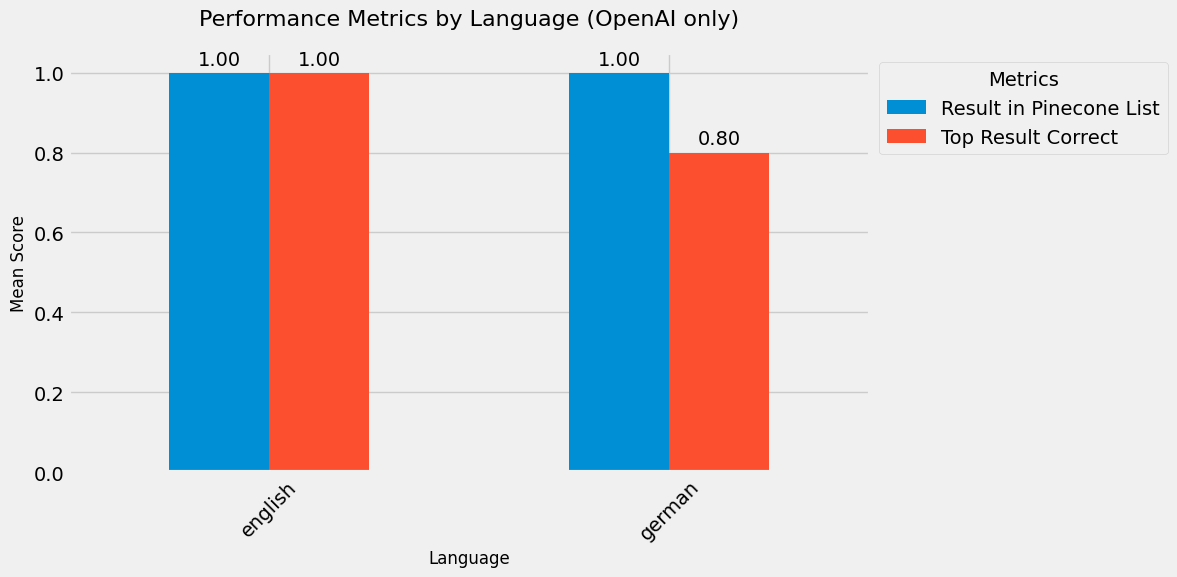

In [130]:
import pandas as pd
results_df = pd.DataFrame(synthetic_test_results)

print(results_df[['result_in_pinecone_list', 'top_result_correct']].mean())

import matplotlib.pyplot as plt

# Assuming you've already created results_df
grouped_data = results_df.groupby('language')[['result_in_pinecone_list', 'top_result_correct']].mean()

# Set the style and color palette
plt.style.use('fivethirtyeight')
# sns.set_palette("deep")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the data
grouped_data.plot(kind='bar', ax=ax)

# Customize the plot
ax.set_title('Performance Metrics by Language (OpenAI only)', fontsize=16, pad=20)
ax.set_xlabel('Language', fontsize=12)
ax.set_ylabel('Mean Score', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add value labels on top of each bar
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

# Add a legend
ax.legend(['Result in Pinecone List', 'Top Result Correct'], title='Metrics', loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Making Retrieval Better with Cohere's Re-Rank

In [131]:
import cohere

load_dotenv()

co = cohere.Client(os.environ.get('COHERE_API_KEY'))